In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

SMALLER_SIZE = 11
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALLER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from curve_models import NLLS, NLLS_w, NLLS_rse, power_law, CurveModel, linearized_power_law
def calc_pct(pred_best, pred_worst, pred_curr):
    return (pred_worst - pred_curr)/(pred_worst - pred_best)

dataset_titles = {'gl': 'GoogleLocal-L', 'gl-tiny': 'GoogleLocal-S', 'ml-20m-tiny': 'MovieLens-S',
                 'ml-20m-uniform': 'MovieLens-L'}
afa_method = 'Weighted'
init_mode = 'uniform'
mltiny_expmt = '0.1_5_False_' + init_mode + '_30_0.5_0.5_5250_21000_213973'
gltiny_expmt = '0.1_5_False_' + init_mode + '30_0.5_0.5_20000_100000_1000001'

gl_expmt = '0.1_5_False_' + init_mode + '_30_0.5_0.5_5800_29000_290001'
ml_expmt = '0.1_5_False_' + init_mode + '_30_0.5_0.5_20000_100000_1000001'
expmts = [('ml-20m-tiny', mltiny_expmt), ('gl-tiny', gltiny_expmt),
          ('ml-20m-uniform',  ml_expmt), ('gl', gl_expmt)]

expmts = [('gl', gl_expmt),  ('gl-tiny', gltiny_expmt), 
           ('ml-20m-uniform', ml_expmt), ('ml-20m-tiny',  mltiny_expmt)]

#expmts = [('gl-tiny', gltiny_expmt),  ('ml-20m-tiny',  mltiny_expmt), ('ml-20m-uniform', ml_expmt)]

In [2]:
all_results = []
suffix = 'qbc_pred_performance'
if afa_method == 'Weighted':
    suffix = 'weighted_pred_performance'

for i, (dataset_name, _) in enumerate(expmts):
    results_df = pd.read_csv('../results/forecasting/' + dataset_name + '/' + suffix)
    results_df = results_df.round({'pred_pct': 2, 'true_pct': 2})
    results_df['dataset'] = dataset_name
    all_results.append(results_df)
    print(len(results_df), dataset_name)
all_results = pd.concat(all_results)

2250 gl
2295 gl-tiny
2475 ml-20m-uniform
1845 ml-20m-tiny


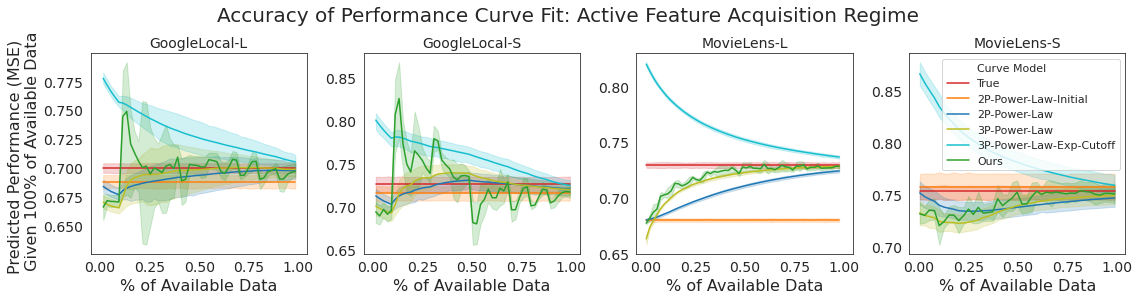

In [3]:
# plot best_mse prediction over pct_available
fig, axs = plt.subplots(1, 4, sharex=True, figsize=(16, 4))
hue_order = ['True', 'NLS_initial', 'NLS_w', 'NLS_power_law_3P', 'NLS_power_law_exp_3P', 'broken']
colors = sns.color_palette("colorblind")
sns.set_palette([colors[3], colors[1], colors[0], colors[8], colors[9], colors[2]])
for i, (dataset_name, _) in enumerate(expmts):

    ax = axs[i]
    forecasting_cms = all_results[all_results['cm'] !='Linear']
    dataset_results = forecasting_cms[forecasting_cms['dataset'] == dataset_name]
    sns.lineplot(x='pct_available', y='pred_best', hue='cm', 
                 hue_order=hue_order,  data=dataset_results, ax=ax)
    ax.set_title(dataset_titles[dataset_name])
    ax.set_xlabel("% of Available Data")
    if i == 0:
        ax.set_ylabel("Predicted Performance (MSE) \n Given 100% of Available Data")
    else:
        ax.set_ylabel("")
    if i != 3:
        ax.get_legend().remove()
    else:
        L=ax.get_legend()
        new_names = ['Curve Model', 'True', '2P-Power-Law-Initial', '2P-Power-Law', '3P-Power-Law', 
                     '3P-Power-Law-Exp-Cutoff', 'Ours']
        for i,new in enumerate(new_names):
            L.get_texts()[i].set_text(new)
plt.tight_layout()
suptitle = plt.suptitle("Accuracy of Performance Curve Fit: Active Feature Acquisition Regime", y=1.05)
plt.savefig('../figs/' + suffix + '.png', bbox_inches='tight',bbox_extra_artists=[suptitle])

KeyboardInterrupt: 

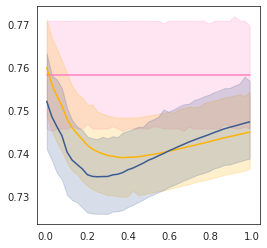

In [17]:
# plot best_mse prediction over pct_available
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(4, 4))
hue_order = ['NLS_initial', 'NLS', 'NLS_w', 'NLS_mix', 'True']
dataset_name = 'ml-20m-tiny'
yname = 'pred_best'
with sns.xkcd_palette(["pink", "amber", "denim blue", "medium green", "red"]):
        forecasting_cms = all_results[all_results['cm'] !='Linear']
        dataset_results = forecasting_cms[forecasting_cms['dataset'] == dataset_name]
        
        sns.lineplot(x='pct_available', y=yname, hue='cm', data=dataset_results, ax=ax, hue_order=hue_order)
        plt.xlabel("Percentage of data collected")
        plt.ylabel("Predicted MSE")
        if 'best' in yname:
            plt.title("Prediction of Best MSE: " + dataset_titles[dataset_name])
            L=ax.get_legend()
            new_names = ['Curve Models', 'Initial', 'NLS', 'NLSw', 'Ours']
            for i,new in enumerate(new_names):
                L.get_texts()[i].set_text(new)
        else:
            plt.title("Prediction of Worst MSE: " + dataset_titles[dataset_name])

        

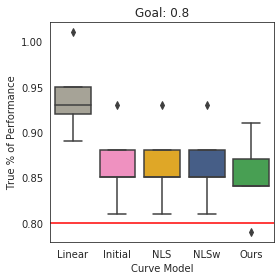

In [105]:
# Plot stopping criterions
goals = [.8]
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(4, 4))
dataset_name = 'ml-20m-tiny'
with sns.xkcd_palette(["greyish", "pink", "amber", "denim blue", "medium green", "red"]):
    for i, g in enumerate(goals):
        ax = axs
        test_df = all_results[all_results['pred_pct'] > g]
        test_df = test_df[test_df['cm'] != 'True']
        draw_df = test_df.sort_values('pred_pct').groupby(['cm', 'run', 'dataset']).first().reset_index()
        dataset_df = draw_df[draw_df['dataset'] == dataset_name]
        sns.boxplot(x='cm', y='true_pct', data=dataset_df, ax=ax,
                    order=['Linear', 'NLS_initial', 'NLS', 'NLS_w', 'NLS_mix'])
        ax.set_xticklabels(['Linear', 'Initial', 'NLS', 'NLSw', 'Ours'])
        ax.axhline(y=g, c='r', label='Goal')
        ax.set_xlabel("Curve Model")
        ax.set_ylabel("True % of Performance")
        ax.set_title("Goal: " + str(g))
        if i > 0:
            ax.set_ylabel("")
        plt.savefig('../figs/' + dataset_name + '_stopping_criterion.png')
plt.tight_layout()
# Filter pred_pct for being greater than goal percentage g 
# Choose the minimum entry, record true percentage
# For a given goal percentage g, at what point do different algorithms stop? 

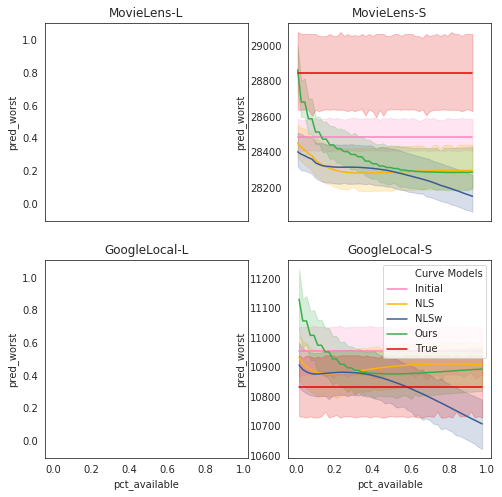

In [106]:
# plot best_mse prediction over pct_available
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(8, 8))
hue_order = ['NLS_initial', 'NLS', 'NLS_w', 'NLS_mix', 'True']
with sns.xkcd_palette(["pink", "amber", "denim blue", "medium green", "red"]):
    for i, (dataset_name, _) in enumerate(expmts):
        ax = axs[int(i/2), i%2]
        forecasting_cms = all_results[all_results['cm'] !='Linear']
        dataset_results = forecasting_cms[forecasting_cms['dataset'] == dataset_name]
        sns.lineplot(x='pct_available', y='pred_worst', hue='cm', data=dataset_results, ax=ax, hue_order=hue_order)
        ax.set_title(dataset_titles[dataset_name])
        if i != 3:
            ax.get_legend().remove()
        else:
            L=ax.get_legend()
            new_names = ['Curve Models', 'Initial', 'NLS', 'NLSw', 'Ours']
            for i,new in enumerate(new_names):
                L.get_texts()[i].set_text(new)

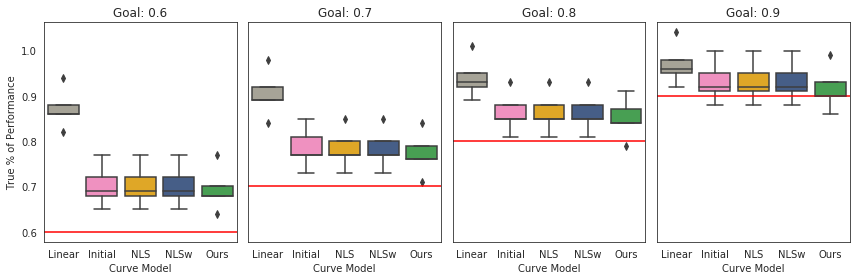

In [107]:
# Plot stopping criterions
goals = [.6, .7, .8, .9]
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(12, 4))
dataset_name = 'ml-20m-tiny'
with sns.xkcd_palette(["greyish", "pink", "amber", "denim blue", "medium green", "red"]):
    for i, g in enumerate(goals):
        ax = axs[i]
        test_df = all_results[all_results['pred_pct'] > g]
        test_df = test_df[test_df['cm'] != 'True']
        draw_df = test_df.sort_values('pred_pct').groupby(['cm', 'run', 'dataset']).first().reset_index()
        dataset_df = draw_df[draw_df['dataset'] == dataset_name]
        sns.boxplot(x='cm', y='true_pct', data=dataset_df, ax=ax,
                    order=['Linear', 'NLS_initial', 'NLS', 'NLS_w', 'NLS_mix'])
        ax.set_xticklabels(['Linear', 'Initial', 'NLS', 'NLSw', 'Ours'])
        ax.axhline(y=g, c='r', label='Goal')
        ax.set_xlabel("Curve Model")
        ax.set_ylabel("True % of Performance")
        ax.set_title("Goal: " + str(g))
        if i > 0:
            ax.set_ylabel("")
        plt.savefig('../figs/' + dataset_name + '_stopping_criterion.png')
plt.tight_layout()
# Filter pred_pct for being greater than goal percentage g 
# Choose the minimum entry, record true percentage
# For a given goal percentage g, at what point do different algorithms stop? 

In [108]:
goals = [.8, .85, .9, .95]
g = .8



In [109]:
# initial
expmt  = '5_False_0.1_0.4_uniform_100000_30_1_1000000_20000_0_0.5_0.5_0_0.8'
dataset_name = 'ml-20m-uniform'
results_path = '../results/forecasting/' + dataset_name + '/Random/' + expmt +'/'
all_ss = np.loadtxt(results_path + 'sample_sizes')
all_mses = np.loadtxt(results_path + 'mses')
nlls_i = NLLS(power_law)
stop_pt = min(np.where(ss > n_init)[0])
nlls_i.fit(ss[:9], mses[:9])
pred_worst = nlls_i.f(n_init, **nlls_i.p)
pred_best = nlls_i.f(n_observable, **nlls_i.p)
pred_curr = nlls_i.f(size, **nlls_i.p)
pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
print(pred_pct)
results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS_initial', 'true_pct': true_pct, 
                'pct_available': pct_available, 'run': j})

# this baseline fits the power law curve to all points
nlls = NLLS(power_law)
nlls.fit(ss[:20], mses[:20])
pred_worst = nlls.f(n_init, **nlls.p)
pred_best = nlls.f(n_observable, **nlls.p)
pred_curr = nlls.f(size, **nlls.p)
pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
print(pred_pct)
results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS', 'true_pct': true_pct, 
                'pct_available': pct_available, 'run': j})

# this method fits the weighted power law curve to all pts
nlls_w = NLLS_w(power_law)
nlls_w.fit(ss[:20], mses[:20])
pred_worst = nlls_w.f(n_init, **nlls_w.p)
pred_best = nlls_w.f(n_observable, **nlls_w.p)
pred_curr = nlls_w.f(size, **nlls_w.p)
pred_pct = calc_pct(pred_best, pred_worst, pred_curr)
print(pred_pct)
results.append({'pred_best': pred_best, 'pred_worst': pred_worst, 'pred_curr': pred_curr,
                'pred_pct': pred_pct, 'true_curr': mse, 'cm': 'NLS_w', 'true_pct': true_pct, 
                'pct_available': pct_available, 'run': j})

0.9894851807434136
0.9895234139776883
0.9895460050220574


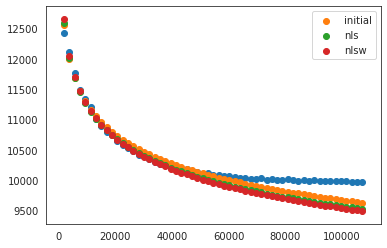

In [110]:
plt.scatter(ss, mses)
plt.scatter(ss, [nlls_i.f(s, **nlls_i.p) for s in ss], label='initial')
plt.scatter(ss, [nlls.f(s, **nlls.p) for s in ss], label='nls')
plt.scatter(ss, [nlls_w.f(s, **nlls_w.p) for s in ss], label='nlsw')
plt.legend()

In [111]:
g = .8
dataset_name = 'ml-tiny'

test_df = all_results[all_results['pred_pct'] > g]
test_df = test_df[test_df['cm'] != 'True']
draw_df = test_df.sort_values('pred_pct').groupby(['cm', 'run', 'dataset']).first().reset_index()
dataset_df = draw_df[draw_df['dataset'] == dataset_name]
ours_df = dataset_df[dataset_df['cm'] == 'NLS_mix']

In [112]:
all_results.keys()

Index(['Unnamed: 0', 'pred_best', 'pred_worst', 'pred_curr', 'pred_pct',
       'true_curr', 'cm', 'true_pct', 'pct_available', 'run', 'dataset'],
      dtype='object')